In [ ]:
import jax.numpy as jnp

In [ ]:
class SquaredExponentialKernel:
    def __init__(self, sigma_f: float = 1, length: float = 1):
        self.sigma_f = sigma_f
        self.length = length

    def __call__(self, argument_1, argument_2) -> float:
        return float(self.sigma_f * jnp.exp(-(jnp.linalg.norm(argument_1 - argument_2) ** 2) / (2 * self.length ** 2)))


# Helper function to calculate the respective covariance matrices
def cov_matrix(x1, x2, cov_function):
    return jnp.array([[cov_function(a, b) for a in x1] for b in x2])


class GPR:
    def __init__(self, data_x, data_y, covariance_function=SquaredExponentialKernel(), white_noise_sigma: float = 0):
        self.noise = white_noise_sigma
        self.data_x = data_x
        self.data_y = data_y
        self.covariance_function = covariance_function

        # Store the inverse of covariance matrix of input (+ machine epsilon on diagonal) since it is needed for every prediction
        self._inverse_of_covariance_matrix_of_input = jnp.linalg.inv(
            cov_matrix(data_x, data_x, covariance_function) +
            (3e-7 + self.noise) * jnp.identity(len(self.data_x)))

        self._memory = None

    # function to predict output at new input values. Store the mean and covariance matrix in memory.
    def predict(self, at_values):
        k_lower_left = cov_matrix(self.data_x, at_values, self.covariance_function)
        k_lower_right = cov_matrix(at_values, at_values, self.covariance_function)

        # Mean.
        mean_at_values = jnp.dot(k_lower_left,
                                 jnp.dot(self.data_y, self._inverse_of_covariance_matrix_of_input.T).T).flatten()

        # Covariance.
        cov_at_values = k_lower_right - jnp.dot(k_lower_left,
                                                jnp.dot(self._inverse_of_covariance_matrix_of_input, k_lower_left.T))

        # Adding value larger than machine epsilon to ensure positive semi definite
        cov_at_values = cov_at_values + 3e-7 * jnp.ones(jnp.shape(cov_at_values)[0])

        var_at_values = jnp.diag(cov_at_values)

        self._memory = {
            'mean': mean_at_values,
            'covariance_matrix': cov_at_values,
            'variance': var_at_values
        }
        return mean_at_values

In [ ]:
x_values = jnp.array([0, 0.3, 1, 3.1, 4.7])

y_values = jnp.array([1, 0, 1.4, 0, -0.9])

x = jnp.arange(-1, 7, 0.1)

In [ ]:
model = GPR(x_values, y_values, SquaredExponentialKernel())
model.predict(x)

In [ ]:
model = GPR(x_values, y_values, SquaredExponentialKernel(sigma_f=0.5, length=.5))

# Scikit-learn

In [2]:
from sklearn import gaussian_process
import matplotlib.pyplot as plt
import numpy as np

In [3]:
kernel = 2.0 ** 2 * gaussian_process.kernels.RBF(2, length_scale_bounds=(1e-7, 1e15))
GP = gaussian_process.GaussianProcessRegressor(kernel, alpha=3e-7)

x_values = np.array([-5, 0, 2, 3.1, 4.7, 10]).reshape(-1, 1)
y_values = np.array([0, 1, 0, 0, -0.9, 0])

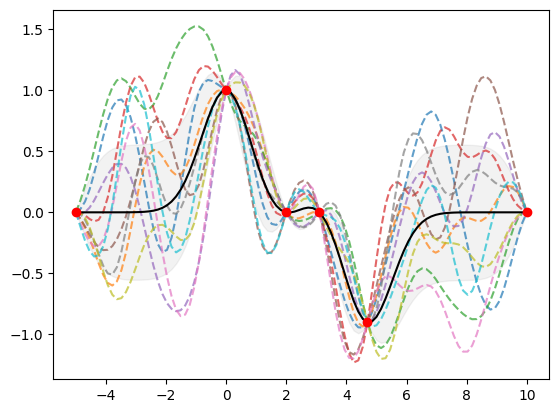

In [6]:
# Plot

fig = plt.Figure(figsize=(16, 9))

x = np.linspace(-5, 10, 100)
X = x.reshape(-1, 1)

y_mean, y_std = GP.predict(X, return_std=True)
y_samples = GP.sample_y(X, 10, random_state=None)

for idx, single_prior in enumerate(y_samples.T):
    plt.plot(x, single_prior, linestyle="--", alpha=0.7, label=f"Sampled function #{idx + 1}")

plt.scatter(x_values[:, 0], y_values, color="red", zorder=10, label="Observations")
plt.plot(x, y_mean, color="black", label="Mean")
plt.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.05, color="black", label=r"$\pm$ 1 std. dev.", )

plt.show()

In [10]:
GP.fit(x_values, y_values)
GP.kernel_

0.554**2 * RBF(length_scale=0.824)

### Using Tree data

In [172]:
import pandas as pd
import seaborn as sns

dendro = pd.read_feather('data/17766_12.feather')
dendro.dendroNr = dendro[['dendroNr', 'year']].astype(str).agg('_'.join, axis=1)  # Merge tree and year
dendro

,dendroNr,year,DOY,species,Plot,growth,dbh
0,HA_001_2012,2012,0,Beech,HEW40,0.000000,151437.432617
1,HA_001_2012,2012,1,Beech,HEW40,0.154100,151437.586208
2,HA_001_2012,2012,2,Beech,HEW40,1.460225,151438.892708
3,HA_001_2012,2012,3,Beech,HEW40,4.169183,151441.601646
4,HA_001_2012,2012,4,Beech,HEW40,3.907183,151441.340000
...,...,...,...,...,...,...,...
30805,SH_076_2013,2013,178,Beech,SEW4,3909.054208,219194.517313
30806,SH_076_2013,2013,179,Beech,SEW4,3908.649604,219194.112896
30807,SH_076_2013,2013,180,Beech,SEW4,3908.473708,219193.937042
30808,SH_076_2013,2013,181,Beech,SEW4,3908.421000,219193.883875


In [221]:
kernel = 1.0 * gaussian_process.kernels.Matern(length_scale=1.0, length_scale_bounds=(1e-1, 1e7), nu=1.5)
tree_model = gaussian_process.GaussianProcessRegressor(kernel)

X = np.array(range(183)).reshape(-1, 1)

tree_model.fit(X, dendro[dendro.dendroNr.eq('HA_001_2012')]['growth'])
tree_model.kernel

1**2 * Matern(length_scale=1, nu=1.5)

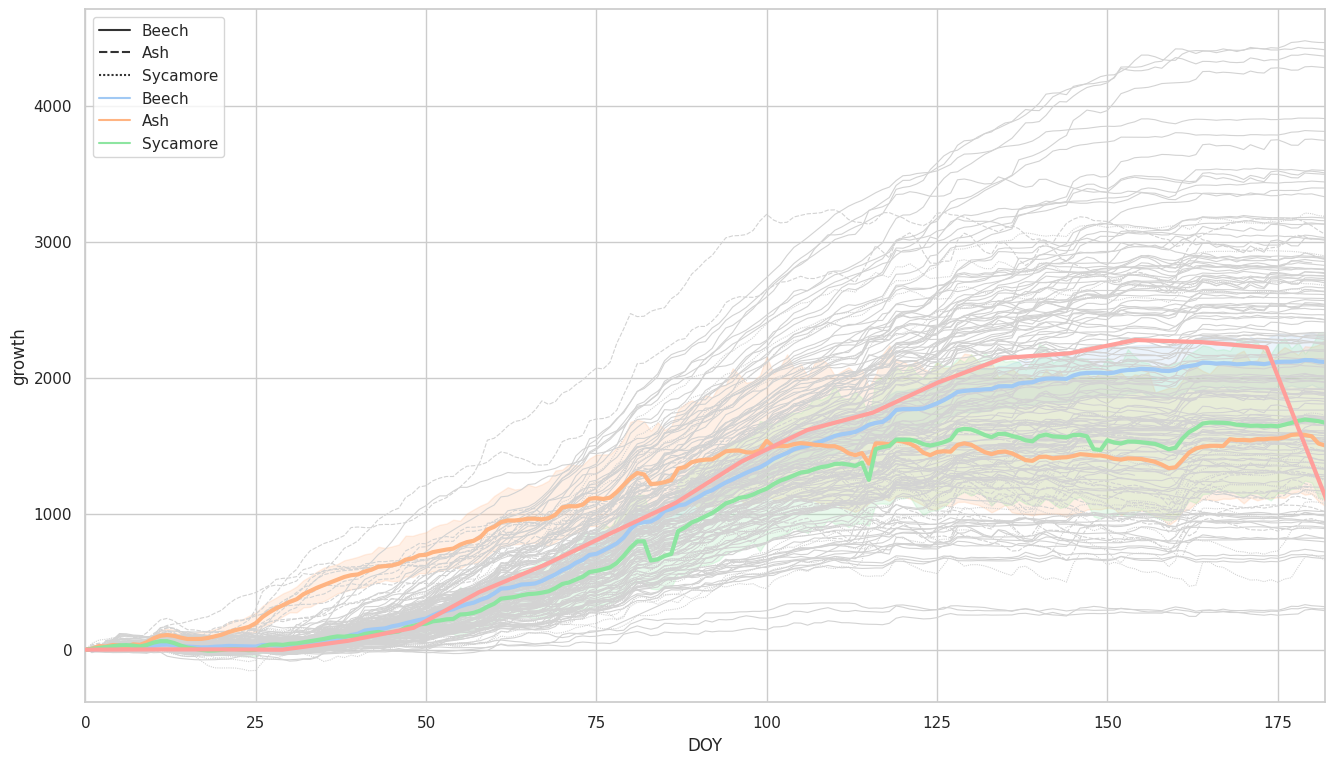

In [223]:
fig = plt.figure(figsize=(16, 9))
sns.set_theme(style="whitegrid", palette="pastel")

# All lines
sns.lineplot(
    data=dendro,
    x='DOY', y='growth', style='species', units='dendroNr',
    lw=.8,
    estimator=None,
    c='lightgray',
)

plt.gca().set(xlim=(0, 182))

# Plot means
sns.lineplot(
    data=dendro,
    x='DOY', y='growth', hue='species',
    estimator='mean',
    errorbar=('ci', 99),
    lw=3,
    zorder=2
)

X_test = np.linspace(0,183,20)
# Plot GP
sns.lineplot(
    x=X_test, y=tree_model.predict(X_test.reshape(-1, 1)),
    lw=3,
    zorder=3
)

plt.show()